# GRU for Time Series Prediction

In this notebook, we will demonstrate how to use Gated Recurrent Units (GRU) neural networks for time series prediction.


In [1]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense  # Note the change to GRU here
from sklearn.preprocessing import MinMaxScaler


2025-09-26 14:42:01.891370: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 14:42:01.892025: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-26 14:42:01.894422: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-26 14:42:01.900533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758879721.911526  406205 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758879721.91

## Data Preparation

First, let's load and visualize the Airline Passengers dataset.


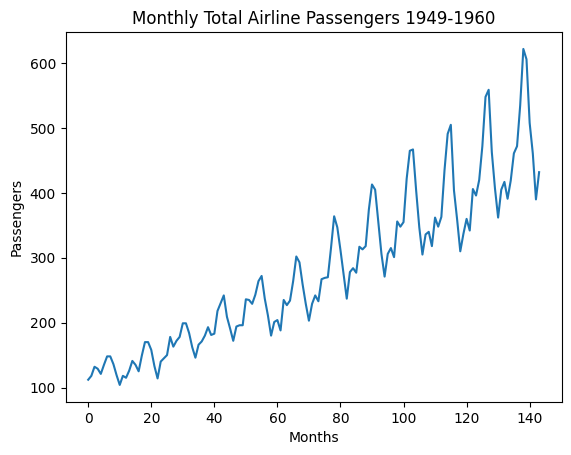

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
dataframe = pd.read_csv(url, usecols=[1], engine='python')
plt.plot(dataframe)
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.title("Monthly Total Airline Passengers 1949-1960")
plt.show()


### Data Preprocessing

Before training a GRU model, we need to preprocess our data. This involves scaling our data and converting it into the right shape.


In [3]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe.values.astype('float32'))

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


### Create Dataset Matrix

This utility function creates a dataset matrix. Given data, and choosing a certain time step, it will create input-output pairs.


In [4]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1, choosing a timestep of 3
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


## GRU Model Building & Training


In [5]:
# Create and fit the GRU network
model = Sequential()
model.add(GRU(4, input_shape=(look_back, 1)))  # Change LSTM to GRU here
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)


Epoch 1/100


2025-09-26 14:42:32.205972: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/tk-lpt-648/miniconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 - 1s - 9ms/step - loss: 0.0744
Epoch 2/100
92/92 - 0s - 1ms/step - loss: 0.0294
Epoch 3/100
92/92 - 0s - 1ms/step - loss: 0.0247
Epoch 4/100
92/92 - 0s - 2ms/step - loss: 0.0219
Epoch 5/100
92/92 - 0s - 1ms/step - loss: 0.0186
Epoch 6/100
92/92 - 0s - 1ms/step - loss: 0.0159
Epoch 7/100
92/92 - 0s - 1ms/step - loss: 0.0135
Epoch 8/100
92/92 - 0s - 1ms/step - loss: 0.0113
Epoch 9/100
92/92 - 0s - 1ms/step - loss: 0.0095
Epoch 10/100
92/92 - 0s - 1ms/step - loss: 0.0077
Epoch 11/100
92/92 - 0s - 1ms/step - loss: 0.0065
Epoch 12/100
92/92 - 0s - 1ms/step - loss: 0.0053
Epoch 13/100
92/92 - 0s - 1ms/step - loss: 0.0046
Epoch 14/100
92/92 - 0s - 1ms/step - loss: 0.0042
Epoch 15/100
92/92 - 0s - 1ms/step - loss: 0.0038
Epoch 16/100
92/92 - 0s - 1ms/step - loss: 0.0037
Epoch 17/100
92/92 - 0s - 1ms/step - loss: 0.0036
Epoch 18/100
92/92 - 0s - 1ms/step - loss: 0.0035
Epoch 19/100
92/92 - 0s - 1ms/step - loss: 0.0035
Epoch 20/100
92/92 - 0s - 1ms/step - loss: 0.0033
Epoch 21/100
92/92 - 

## Model Evaluation


In [6]:
# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# Calculate root mean squared error
trainScore = np.sqrt(((trainPredict-y_train)**2).mean())
testScore = np.sqrt(((testPredict-y_test)**2).mean())
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Train Score: 96.47 RMSE
Test Score: 101.48 RMSE


## Visualizing Predictions


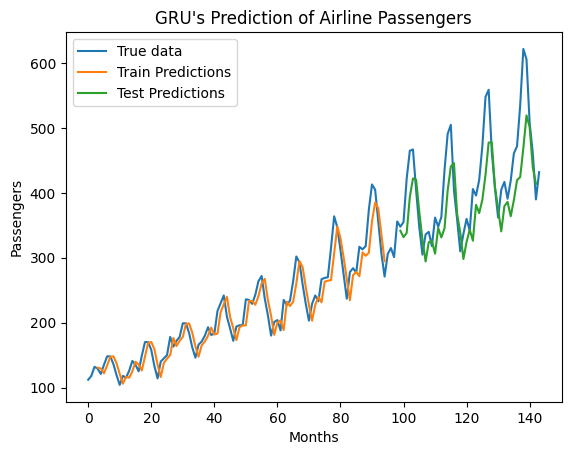

In [7]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label="True data")
plt.plot(trainPredictPlot, label="Train Predictions")
plt.plot(testPredictPlot, label="Test Predictions")
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.title("GRU's Prediction of Airline Passengers")
plt.legend()
plt.show()
